<a href="https://colab.research.google.com/github/Anjasfedo/Code-as-a-Cryptography/blob/main/ecc_lsb_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elliptic Curve Criptography

with library that use schema of ECDH + AES
1. Elliptic Curve Diffle Hellman for key exchange
2. AES to encrypt & decrypt the massage/plaintext

In [1]:
!pip install eciespy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00


In [2]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [3]:
from ecies.utils import generate_eth_key
from ecies import encrypt, decrypt

private_key = generate_eth_key()
public_key = private_key.public_key

public_key_hex = public_key.to_hex()
private_key_hex = private_key.to_hex()

print("Public Key:", public_key_hex)
print("Private Key:", private_key_hex)

ciphertext = encrypt(public_key_hex, CONTENT.encode())

print("Ciphertext:", ciphertext.hex())

decrypted_message = decrypt(private_key_hex, ciphertext)
print("Decrypted Message:", decrypted_message.decode())

Public Key: 0xfaa864aea09da42dc507c733600d7d88ef393a9b5fe907d6c2b62f6891bc2b3aba0fc29f4ada22765157d5fc918854aa0218f42a1ac3846ccb8d9bb0ca446cdc
Private Key: 0x12e9fa3f016755e5048b0accd80b7f3df9eb08c08569f49e2a3b5a599dc55211
Ciphertext: 044dd885aa2d6478a637ae3339fda8f5c2f139215f5e82cca8ca240301e4a51bcadf58621af0cadd41f84a3ff8cc8080668aca1a9b3f5fe7213ef4ad5a7bf7f698784db6f3479038593b3863e52e608a7a36d9b29e6954c9165db4406c1504ae50a80c482c146fd0362d5bb200dc322c46c4e2d5561c2772196a3710d48d427166221a10dc26d74d217112122e85d1099d27ab154e1424fbca4005ef4fc07b1abfc3ee3062ccd03a366655bf6d9d92a40abb82f4bcd16124cfc496ec3a0d7fdbf971f24c053447a95881e51993a87630874a341d5d1603803a52761a76cfed94ddc64b899e0f525079ecef17655e0bb0f8e61f332e3b49df026fa6a80963a0447718220b1e530129d7f913b00ddacbfc2f09
Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


# Koblitz Method & Elliptic Curve El Gamal

## Koblitz Method

to encode & decode integer to coordinate point on cartesius

In [4]:
# Parameters
p = 751  # prime modulus
k = 20    # chosen small integer
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

### Char to Num & Num to Char

In [5]:
# Manually create dictionaries for char-to-num and num-to-char mappings
char_to_num_dict = {
    '0': 10, '1': 11,
    'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19,
    'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27,
    'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35
}

# Reverse dictionary for num-to-char mapping
num_to_char_dict = {v: k for k, v in char_to_num_dict.items()}

# Function to map char to num
def char_to_num(char):
    if char in char_to_num_dict:
        return char_to_num_dict[char]
    else:
        raise ValueError(f"Character '{char}' is not valid. Please use '0-1' or 'a-x'.")

# Function to map num to char
def num_to_char(num):
    if num in num_to_char_dict:
        return num_to_char_dict[num]
    else:
        raise ValueError(f"Number '{num}' is not valid. Please use numbers in the range 10-35.")

def message_to_koblitz(message):
    # Convert the message to a list of characters
    chars = list(message)

    koblitz = []
    for char in chars:
        num = char_to_num(char)
        koblitz.append(num)

    return koblitz

def koblitz_to_message(koblitz):
    message = []
    for num in koblitz:
        char = num_to_char(num)
        message.append(char)

    return ''.join(message)

# Test mapping from char to num
chars = '01ax'

koblitz_message = message_to_koblitz(chars)
print("Koblitz Message:", koblitz_message)

message = koblitz_to_message(koblitz_message)
print("Message:", message)

Koblitz Message: [10, 11, 12, 35]
Message: 01ax


### Koblitz Encoding

In [6]:
import sympy as sp

# Elliptic curve equation: y^2 = x^3 + ax + b mod p
def koblitz_encode(m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * k + num
        rhs = (x**3 + a * x + b) % p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, p):
            y = sp.sqrt_mod(rhs, p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

def koblitz_encode_message(message):
  encoded_points = []
  for char in message:
    encoded_point = koblitz_encode(char)
    encoded_points.append(encoded_point)
    print(f"Encoded point for character '{char}': {encoded_point}")

  return encoded_points

encoded_points = koblitz_encode_message(koblitz_message)
encoded_points

Encoded point for character '10': (201, 5)
Encoded point for character '11': (224, 248)
Encoded point for character '12': (241, 230)
Encoded point for character '35': (701, 203)


[(201, 5), (224, 248), (241, 230), (701, 203)]

### Koblitz Decoding

In [7]:
# Decoding: m = (x - 1) / k
def koblitz_decode(x):
    return (x - 1) // k

def koblitz_decode_message(points):
    decoded_message = []
    for point in points:
        decoded_num = koblitz_decode(point[0])  # Decode the x-coordinate
        decoded_message.append(decoded_num)
        print(f"Decoded character for point {point}: {decoded_num}")
    return decoded_message

# Output the result
decoded_points = koblitz_decode_message(encoded_points)
decoded_points

Decoded character for point (201, 5): 10
Decoded character for point (224, 248): 11
Decoded character for point (241, 230): 12
Decoded character for point (701, 203): 35


[10, 11, 12, 35]

In [8]:
message = koblitz_to_message(decoded_points)
message

'01ax'

## Elliptic Curve El Gamal

Elliptic Curve with El Gamal

In [9]:
# Parameters
p = 11  # prime modulus
# k = 20    # chosen small integer
a = 1    # coefficient of x in the elliptic curve
b = 6    # constant in the elliptic curve
# B = (2, 4)

In [10]:
# Parameters
p = 751  # prime modulus
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

In [11]:
import random
import sympy as sp
import json
import base64

class EllipticCurveElGamal:
  def __init__(self, a, b, p, k, B=None):
    self.p = p # primer number
    self.a = a # alpha
    self.b = b # beta

    self.k = k
    self.PointB = B

    self.pointP = None
    self.pointQ = None

    self.char_to_num_dict = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17,
    'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25,
    'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33,
    'y': 34, 'z': 35, '.': 36, '#': 37, '*': 38, '/': 39, '-': 40
    }

    self.num_to_char_dict = {v: k for k, v in self.char_to_num_dict.items()}

    self.k_koblitz = max(self.char_to_num_dict.values()) + 1  # max 24 for 35 char

  def example_function(self):
      print(f"Using persistent k value: {self.k}")

  def elliptic_curve_equation(self, x):
    return (x**3 + self.a*x + self.b) % self.p

  def is_on_curve(self, x, y):
    return self.elliptic_curve_equation(x)  == (y**2) % p

  # def generate_random_number(self):
  #   self.k = random.randint(1, self.p - 1)
  #   return self.k

  def generate_random_point(self):
    while True:
      x = random.randint(1, self.p - 1)
      y = random.randint(1, self.p - 1)
      if self.is_on_curve(x, y):
        return (x, y)

  def mod_inverse(self, a, p):
      if a == 0:
          raise ValueError("Inverse does not exist for 0.")
      return pow(a, p - 2, p)

  def calculate_slope_mod(self, P, Q):
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and y1 == y2:
        # Use the formula for point doubling when P == Q
        numerator = (3 * x1**2 + self.a) % self.p
        denominator = (2 * y1) % self.p
    else:
        # Use the formula for regular slope when P != Q
        numerator = (y2 - y1) % self.p
        denominator = (x2 - x1) % self.p

    if denominator == 0:
        raise ValueError("Slope is undefined (denominator is zero).")

    # Compute the slope as (numerator / denominator) % p, which is
    # numerator * mod_inverse(denominator, p) % p
    slope = (numerator * self.mod_inverse(denominator, self.p)) % self.p
    return slope

  def calculate_add_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - x1 - x2) % self.p
    return xr

  def calculate_add_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    x2, y2 = Q
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_addition(self, P, Q):
    m = self.calculate_slope_mod(P, Q)

    xr = self.calculate_add_xr_mod(P, Q, m)

    yr = self.calculate_add_yr_mod(P, Q, m, xr)

    R = (xr, yr)

    return R

  def calculate_dob_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - (2 * x1)) % self.p
    return xr

  def calculate_dob_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_doubling(self, P):

    m = self.calculate_slope_mod(P, P)

    xr = self.calculate_dob_xr_mod(P, P, m)

    yr = self.calculate_dob_yr_mod(P, P, m, xr)

    R = (xr, yr)

    return R

  def calculate_point_multiplication(self, P, k):
    if k == 0:
      return None
    elif k == 1:
      return P

    # Initialize R to be the point at infinity, often represented as None in this context
    R = None
    Q = P  # Start with Q as P

    # Double-and-add method
    while k > 0:
        if k % 2 == 1:  # If k is odd, add Q to the result
            if R is None:
                R = Q  # R is the point at infinity initially
            else:
                R = self.calculate_point_addition(R, Q)
        Q = self.calculate_point_addition(Q, Q)  # Double the point Q
        k //= 2  # Move to the next bit

    return R

  def calculate_point_subtract(self, P, Q):
    # Find the inverse of point Q (x_Q, y_Q) -> (x_Q, -y_Q mod p)
    Q_inv = (Q[0], (-Q[1]) % self.p)

    # Subtract P - Q by adding P and Q_inv
    R = self.calculate_point_addition(P, Q_inv)

    return R

  def generate_public_key(self, B, private_key):
    public_key = self.calculate_point_multiplication(B, private_key)
    return public_key

  def enryption(self, M, public_key):
    # k = random.randint(1, self.p - 1) # 1 < k < p - 1

    C1 = self.calculate_point_multiplication(self.PointB, self.k)
    C2 = self.calculate_point_addition(M, self.calculate_point_multiplication(public_key, self.k))

    return (C1, C2)

  def decryption(self, C, private_key):
    C1, C2 = C

    _p = self.calculate_point_multiplication(C1, private_key)

    plain = self.calculate_point_subtract(C2, _p)

    return plain

  # Function to map char to num
  def char_to_num(self, char):
      # Ensure the input is a string; if not, convert it
      char = str(char)

      # Check if the string exists in the dictionary
      if char in self.char_to_num_dict:
          return self.char_to_num_dict[char]
      else:
          # Handle the expanded character set (0-40)
          raise ValueError(f"Character '{char}' is not valid. Please use '0-9', 'a-z', or other valid characters.")


  # Function to map num to char
  def num_to_char(self, num):
      # Ensure that the input is an integer; if it's a string digit, convert to integer
      if isinstance(num, str) and num.isdigit():
          num = int(num)

      # Now we expect num to be an integer
      if isinstance(num, int):
          if num in self.num_to_char_dict:  # Handle numbers 0-40 by converting them using the dictionary
              return self.num_to_char_dict[num]
          else:
              raise ValueError(f"Number '{num}' is out of the valid range (0-40).")
      else:
          raise ValueError(f"Input '{num}' is not valid. Please provide a valid number.")


  def message_to_koblitz(self, message):
      # Convert the message to a list of characters
      chars = list(message)

      koblitz = []
      for char in chars:
          num = self.char_to_num(char)
          koblitz.append(num)

      return koblitz

  def koblitz_to_message(self, koblitz):
      message = []
      for num in koblitz:
          char = self.num_to_char(num)
          message.append(char)

      return ''.join(message)

  def koblitz_encode(self, m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * self.k_koblitz + num
        rhs = (x**3 + self.a * x + self.b) % self.p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, self.p):
            y = sp.sqrt_mod(rhs, self.p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

  def koblitz_encode_message(self, message):
    encoded_points = []
    for char in message:
      encoded_point = self.koblitz_encode(char)
      encoded_points.append(encoded_point)
      # print(f"Encoded point for character '{char}': {encoded_point}")

    return encoded_points

  def koblitz_decode(self, x):
    return (x - 1) // self.k_koblitz

  def koblitz_decode_message(self, points):
      decoded_message = []
      for point in points:
          decoded_num = self.koblitz_decode(point[0])  # Decode the x-coordinate
          decoded_message.append(decoded_num)
          # print(f"Decoded character for point {point}: {decoded_num}")
      return decoded_message

  def encrypt_message(self, message, public_key):
      # Encode the message into Koblitz points
      koblitz_message = self.message_to_koblitz(message)
      encoded_message = self.koblitz_encode_message(koblitz_message)
      encrypted_points = []

      # Encrypt each Koblitz point
      for point in encoded_message:
          encrypted_point = self.enryption(point, public_key)
          encrypted_points.append(encrypted_point)

      # Convert encrypted_points (a list of tuples) to a JSON string
      encrypted_message_string = json.dumps(encrypted_points)

      # Optionally, encode the string to base64 for a cleaner ciphertext
      encrypted_message_base64 = base64.b64encode(encrypted_message_string.encode()).decode()

      return encrypted_message_base64, encrypted_points  # Return as readable string

  def decrypt_message(self, encrypted_message_base64, private_key):
      # Decode the base64 string back to the JSON string
      encrypted_message_string = base64.b64decode(encrypted_message_base64).decode()

      # Convert the JSON string back to a list of encrypted points (tuples)
      encrypted_points = json.loads(encrypted_message_string)

      decrypted_message = []

      # Decrypt each point
      for point in encrypted_points:
          decrypted_point = self.decryption(point, private_key)
          decrypted_message.append(decrypted_point)

      # Decode the Koblitz points into the original numeric values
      decoded_koblitz_points = self.koblitz_decode_message(decrypted_message)

      # Convert numeric Koblitz points to characters using num_to_char
      plain_text_message = ''.join([self.num_to_char(num) for num in decoded_koblitz_points])

      return plain_text_message

In [12]:
random_num = random.randint(1, p - 1)
print(f'random number: {random_num}')

elliptic1 = EllipticCurveElGamal(a, b, p, random_num)

# k = elliptic1.generate_random_number()
# print(f'k: {k}')

basis = elliptic1.generate_random_point()
print(f'basis: {basis}')

elliptic1.PointB = basis

print(f'is basis on curve: {elliptic1.is_on_curve(basis[0], basis[1])}')

random number: 710
basis: (311, 640)
is basis on curve: True


In [13]:
private_key = random.randint(1, p - 1)
public_key = elliptic1.generate_public_key(basis, private_key)

print(f'private key: {private_key}')
print(f'public key: {public_key}')

private key: 526
public key: (676, 558)


In [14]:
message = (385, 423)

cipher = elliptic1.enryption(message, public_key)

decrypted_message = elliptic1.decryption(cipher, private_key)

print(f'message: {message}')
print(f'cipher: {cipher}')
print(f'decrypted message: {decrypted_message}')

message: (385, 423)
cipher: ((74, 199), (723, 304))
decrypted message: (385, 423)


In [15]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [16]:
elliptic1.k_koblitz = 18 # max 18 if add "-#./*"

# plaintexts = "-#./*"
plaintexts = "lorem.#-/*"
# plaintexts = CONTENT
print(f'Plaintext: {plaintexts}')

ciphertexts, points_cipher = elliptic1.encrypt_message(plaintexts, public_key)
print(f'Ciphertext: {ciphertexts}')

decrypted_message = elliptic1.decrypt_message(ciphertexts, private_key)
print(f'Decryptedtext: {decrypted_message}')

Plaintext: lorem.#-/*
Ciphertext: W1tbNzQsIDE5OV0sIFs0MjMsIDYxNl1dLCBbWzc0LCAxOTldLCBbNTg0LCA0ODBdXSwgW1s3NCwgMTk5XSwgWzI5MSwgMTZdXSwgW1s3NCwgMTk5XSwgWzY4MywgNDA4XV0sIFtbNzQsIDE5OV0sIFszMjQsIDddXSwgW1s3NCwgMTk5XSwgWzMwNCwgNTg2XV0sIFtbNzQsIDE5OV0sIFsyMTcsIDUwNF1dLCBbWzc0LCAxOTldLCBbMjY1LCA3Nl1dLCBbWzc0LCAxOTldLCBbNDQsIDMxMl1dLCBbWzc0LCAxOTldLCBbNDA2LCA1NTddXV0=
Decryptedtext: lorem.#-/*


In [17]:
len(ciphertexts)

328

In [18]:
points_cipher

[((74, 199), (423, 616)),
 ((74, 199), (584, 480)),
 ((74, 199), (291, 16)),
 ((74, 199), (683, 408)),
 ((74, 199), (324, 7)),
 ((74, 199), (304, 586)),
 ((74, 199), (217, 504)),
 ((74, 199), (265, 76)),
 ((74, 199), (44, 312)),
 ((74, 199), (406, 557))]

In [19]:
points_cipher

[((74, 199), (423, 616)),
 ((74, 199), (584, 480)),
 ((74, 199), (291, 16)),
 ((74, 199), (683, 408)),
 ((74, 199), (324, 7)),
 ((74, 199), (304, 586)),
 ((74, 199), (217, 504)),
 ((74, 199), (265, 76)),
 ((74, 199), (44, 312)),
 ((74, 199), (406, 557))]

In [20]:
decrypted_message == CONTENT

False

In [21]:
len(ciphertexts)

328

# Least Significant Bit

In [22]:
!git clone https://github.com/RobinDavid/LSB-Steganography && cd LSB-Steganography && ls && pip install -r requirements.txt

Cloning into 'LSB-Steganography'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 75 (delta 1), reused 2 (delta 0), pack-reused 68 (from 1)
Receiving objects: 100% (75/75), 19.72 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (26/26), done.
LICENCE  LSBSteg.py  README.md	requirements.txt
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8bda4849f940f9b1eabba39a8b66b10517adf1feea603b9a0d736d7737463c27
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [23]:
#!/usr/bin/env python
# coding:UTF-8
"""LSBSteg.py

Usage:
  LSBSteg.py encode -i <input> -o <output> -f <file>
  LSBSteg.py decode -i <input> -o <output>

Options:
  -h, --help                Show this help
  --version                 Show the version
  -f,--file=<file>          File to hide
  -i,--in=<input>           Input image (carrier)
  -o,--out=<output>         Output image (or extracted file)
"""

import cv2
import docopt
import numpy as np


class SteganographyException(Exception):
    pass


class LSBSteg():
    def __init__(self, im):
        self.image = im
        self.height, self.width, self.nbchannels = im.shape
        self.size = self.width * self.height

        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations

        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)

        self.curwidth = 0  # Current width position
        self.curheight = 0 # Current height position
        self.curchan = 0   # Current channel position

    def put_binary_value(self, bits): #Put the bits in the image
        for c in bits:
            val = list(self.image[self.curheight,self.curwidth]) #Get the pixel value as a list
            if int(c) == 1:
                val[self.curchan] = int(val[self.curchan]) | self.maskONE #OR with maskONE
            else:
                val[self.curchan] = int(val[self.curchan]) & self.maskZERO #AND with maskZERO

            self.image[self.curheight,self.curwidth] = tuple(val)
            self.next_slot() #Move "cursor" to the next space

    def next_slot(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("No available slot remaining (image filled)")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1

    def read_bit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth][self.curchan]
        val = int(val) & self.maskONE
        self.next_slot()
        if val > 0:
            return "1"
        else:
            return "0"

    def read_byte(self):
        return self.read_bits(8)

    def read_bits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.read_bit()
        return bits

    def byteValue(self, val):
        return self.binary_value(val, 8)

    def binary_value(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException(f"binary value larger than the expected size {len(binval)} > {bitsize}")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    def encode_text(self, txt):
        l = len(txt)
        binl = self.binary_value(l, 16) #Length coded on 2 bytes so the text size can be up to 65536 bytes long
        self.put_binary_value(binl) #Put text length coded on 4 bytes
        for char in txt: #And put all the chars
            c = ord(char)
            self.put_binary_value(self.byteValue(c))
        return self.image

    def decode_text(self):
        ls = self.read_bits(16) #Read the text size in bytes
        l = int(ls,2)
        i = 0
        unhideTxt = ""
        while i < l: #Read all bytes of the text
            tmp = self.read_byte() #So one byte
            i += 1
            unhideTxt += chr(int(tmp,2)) #Every chars concatenated to str
        return unhideTxt

    def encode_image(self, imtohide):
        w = imtohide.width
        h = imtohide.height
        if self.width*self.height*self.nbchannels < w*h*imtohide.channels:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        binw = self.binary_value(w, 16) #Width coded on to byte so width up to 65536
        binh = self.binary_value(h, 16)
        self.put_binary_value(binw) #Put width
        self.put_binary_value(binh) #Put height
        for h in range(imtohide.height): #Iterate the hole image to put every pixel values
            for w in range(imtohide.width):
                for chan in range(imtohide.channels):
                    val = imtohide[h,w][chan]
                    self.put_binary_value(self.byteValue(int(val)))
        return self.image


    def decode_image(self):
        width = int(self.read_bits(16),2) #Read 16bits and convert it in int
        height = int(self.read_bits(16),2)
        unhideimg = np.zeros((width,height, 3), np.uint8) #Create an image in which we will put all the pixels read
        for h in range(height):
            for w in range(width):
                for chan in range(unhideimg.channels):
                    val = list(unhideimg[h,w])
                    val[chan] = int(self.read_byte(),2) #Read the value
                    unhideimg[h,w] = tuple(val)
        return unhideimg

    def encode_binary(self, data):
        l = len(data)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.put_binary_value(self.binary_value(l, 64))
        for byte in data:
            byte = byte if isinstance(byte, int) else ord(byte) # Compat py2/py3
            self.put_binary_value(self.byteValue(byte))
        return self.image

    def decode_binary(self):
        l = int(self.read_bits(64), 2)
        output = b""
        for i in range(l):
            output += bytearray([int(self.read_byte(),2)])
        return output


def main():
    args = docopt.docopt(__doc__, version="0.2")
    in_f = args["--in"]
    out_f = args["--out"]
    in_img = cv2.imread(in_f)
    steg = LSBSteg(in_img)
    lossy_formats = ["jpeg", "jpg"]

    if args['encode']:
        #Handling lossy format
        out_f, out_ext = out_f.split(".")
        if out_ext in lossy_formats:
            out_f = out_f + ".png"
            print("Output file changed to ", out_f)

        data = open(args["--file"], "rb").read()
        res = steg.encode_binary(data)
        cv2.imwrite(out_f, res)

    elif args["decode"]:
        raw = steg.decode_binary()
        with open(out_f, "wb") as f:
            f.write(raw)

# if __name__=="__main__":
#     main()

# Lampel Ziv Welch

In [24]:
!git clone https://github.com/joeatwork/python-lzw

Cloning into 'python-lzw'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80 (from 1)
Receiving objects: 100% (80/80), 3.22 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [25]:
!cd /content/python-lzw && mv lzw/ /content/ && python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [26]:
import lzw

# Example text to compress (can be any string)
original_text = CONTENT

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Original Bytes: b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Compressed List (Byte Chunks): [b'\x19', b'\x8c', b'\xc6', b'\x83', b'\x81', b'\xb0', b'\xc4', b'`', b'4', b'\x18', b'\x0c', b'G', b'#', b'q', b'\x84', b'8', b'j', b'#', b'1', b'\x9a', b'\x0e', b'F', b'\x93', b'\x99', b'\xd0', b'\xde', b'f', b'2', b'\x9c', b'\x85', b'F', b'H', b'\xd1', b'\xa4', b'\xc2', b'n', b'\x15', b'\x18', b'\x8e', b'\xa6', b'H', b'\xf9', b'\xba', b'.', b'#', b':', b'\x19', b'L', b'\xe6', b'\x13', b'`', b'\x8e', b'\x17', b'\x0c', b'\x16', b'\x8c', b'\x06', b's', b'!', b'\xa0', b'\x8c', b'\xd8', b'a', b'5', b'\x9a', b'E', b'\xb3', b'\x89', b'\xd0', b'\x8c', b'\xc4', b'#', b'

# Huffman Encoding

In [27]:
import heapq
from collections import Counter

# Class for Huffman Tree Nodes
class HuffmanNode:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman Tree
def build_huffman_tree(frequency):
    heap = [HuffmanNode(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq, left=node1, right=node2)
        heapq.heappush(heap, merged)

    return heap[0]  # Return the root of the tree

# Function to generate Huffman codes from the Huffman Tree
def generate_huffman_codes(node, current_code="", huffman_codes={}):
    if node is None:
        return

    if node.char is not None:
        huffman_codes[node.char] = current_code

    generate_huffman_codes(node.left, current_code + "0", huffman_codes)
    generate_huffman_codes(node.right, current_code + "1", huffman_codes)

    return huffman_codes

# Function to compress the data using Huffman Encoding
def huffman_compress(data):
    # Count the frequency of each byte
    frequency = Counter(data)

    # Build Huffman Tree
    huffman_tree = build_huffman_tree(frequency)

    # Generate Huffman Codes
    huffman_codes = generate_huffman_codes(huffman_tree)

    # Encode data into its binary representation
    encoded_data = "".join(huffman_codes[byte] for byte in data)

    # Pad the encoded data to make its length a multiple of 8
    padding = 8 - len(encoded_data) % 8
    encoded_data += "0" * padding
    padding_info = "{0:08b}".format(padding)

    # Convert binary data to bytes
    compressed_data = bytearray()
    compressed_data.append(int(padding_info, 2))  # First byte stores the padding information
    for i in range(0, len(encoded_data), 8):
        byte = encoded_data[i:i+8]
        compressed_data.append(int(byte, 2))

    return compressed_data, huffman_tree

# Function to decompress the data using Huffman Encoding
def huffman_decompress(compressed_data, huffman_tree):
    # Convert the compressed data to binary string
    encoded_data = ""
    for byte in compressed_data[1:]:
        encoded_data += "{0:08b}".format(byte)

    # Get the padding information from the first byte
    padding = compressed_data[0]
    encoded_data = encoded_data[:-padding]  # Remove padding

    # Traverse the Huffman tree to decode the binary string
    decoded_data = bytearray()
    node = huffman_tree
    for bit in encoded_data:
        if bit == "0":
            node = node.left
        else:
            node = node.right

        if node.left is None and node.right is None:  # Leaf node
            decoded_data.append(node.char)
            node = huffman_tree

    return decoded_data


# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = CONTENT.encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

# Step 3: Decompress the compressed data back to the original plaintext
decompressed_data = huffman_decompress(compressed_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

# Step 4: Verify that the decompressed data matches the original data
if decompressed_data == plaintext:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Data (as bytes): b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Original Data (as string): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Compressed Data (in bytes): bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')
Decompressed Data (as bytes): bytearray(b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup')

# Test Image

In [28]:
import os
# Directory where the image will be saved
ori_dir_img = "ori-image"

# Create the ori_dir_img if it doesn't exist
if not os.path.exists(ori_dir_img):
    os.makedirs(ori_dir_img)

stego_dir_img = "stego-image"

# Create the stego_dir_img if it doesn't exist
if not os.path.exists(stego_dir_img):
    os.makedirs(stego_dir_img)

## Lena Image

In [29]:
import requests
from PIL import Image
import io

# URL to the raw image file
url = "https://raw.githubusercontent.com/mikolalysenko/lena/master/lena.png"

# Download the image
response = requests.get(url)
if response.status_code == 200:
    # Load the image using PIL
    lena_image = Image.open(io.BytesIO(response.content))
    lena_image.show()  # Display the image (optional)
    lena_image.save("ori-image/lena.png")  # Save the image locally
else:
    print("Failed to download the image.")

In [30]:
LENA_IMG = 'ori-image/lena.png'

if not os.path.exists(LENA_IMG):
    raise FileNotFoundError(f"Image not found at {LENA_IMG}")

## Pappers Image

In [33]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [34]:
pappers_IMG = '/content/drive/MyDrive/stego/cover/pappers.tiff'

if not os.path.exists(pappers_IMG):
    raise FileNotFoundError(f"Image not found at {pappers_IMG}")

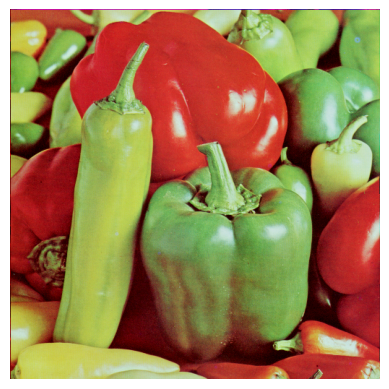

In [35]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(pappers_IMG)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [36]:
img.size, img.info, img.mode, img.format

((512, 512),
 {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)},
 'RGB',
 'TIFF')

## Aiplane Image

In [37]:
airplane_IMG = '/content/drive/MyDrive/stego/cover/airplane.tiff'

if not os.path.exists(airplane_IMG):
    raise FileNotFoundError(f"Image not found at {airplane_IMG}")

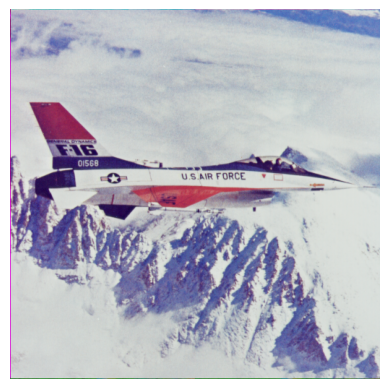

In [38]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(airplane_IMG)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [39]:
img.size, img.info, img.mode, img.format

((512, 512),
 {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)},
 'RGB',
 'TIFF')

## Couple Image

In [40]:
couple_IMG = '/content/drive/MyDrive/stego/cover/couple.tiff'

if not os.path.exists(couple_IMG):
    raise FileNotFoundError(f"Image not found at {couple_IMG}")

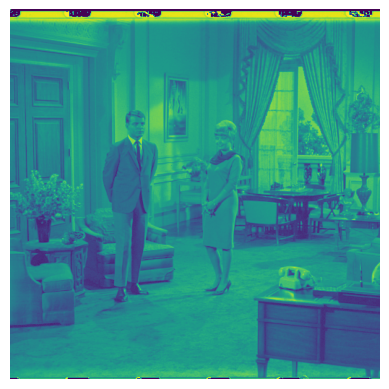

In [41]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(couple_IMG)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [42]:
img.size, img.info, img.mode, img.format

((512, 512),
 {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)},
 'L',
 'TIFF')

## Boat Image

In [45]:
boat_IMG = '/content/drive/MyDrive/stego/cover/boat.tiff'

if not os.path.exists(boat_IMG):
    raise FileNotFoundError(f"Image not found at {boat_IMG}")

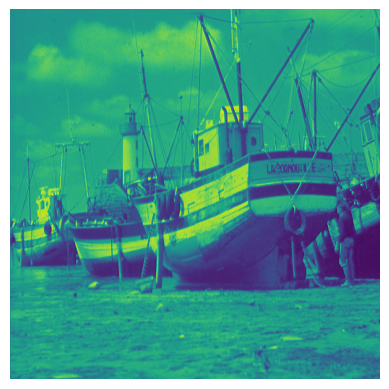

In [46]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(boat_IMG)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [47]:
img.size, img.info, img.mode, img.format

((512, 512),
 {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)},
 'L',
 'TIFF')

## Baboon Image

In [49]:
baboon_IMG = '/content/drive/MyDrive/stego/cover/baboon.tiff'

if not os.path.exists(baboon_IMG):
    raise FileNotFoundError(f"Image not found at {baboon_IMG}")

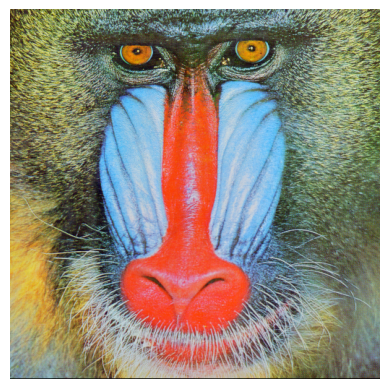

In [50]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(baboon_IMG)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [51]:
img.size, img.info, img.mode, img.format

((512, 512),
 {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)},
 'RGB',
 'TIFF')

# Steganography Metric

## MSE

In [ ]:
def calculate_mse(original, stego):
    return np.mean((original - stego) ** 2)

## PSNR

In [ ]:
def calculate_psnr(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate MSE using the separated function
    mse = calculate_mse(original, stego)
    if mse == 0:  # If images are identical
        return float('inf')

    # Calculate PSNR using the 10 log10 version
    max_pixel_value = 255.0
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    # print(f'PSNR: {psnr}')
    return psnr

## SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, stego):
    # Convert images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_value, _ = ssim(original_gray, stego_gray, full=True)
    return ssim_value

## Get it together

In [ ]:
def calculate_stego_metrics(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate metrics
    mse_value = calculate_mse(original, stego)
    psnr_value = calculate_psnr(target)
    ssim_value = calculate_ssim(original, stego)

    # Print results
    print(f'Metrics between original ({ori_image}) and stego image ({target}):')
    print(f'MSE: {mse_value}')
    print(f'PSNR: {psnr_value}')
    print(f'SSIM: {ssim_value}')

    return mse_value, psnr_value, ssim_value

# LSB Helper

In [ ]:
def embed_lsb(target, content, ori_img = LENA_IMG):
  steg = LSBSteg(cv2.imread(ori_img))

  img_encoded = steg.encode_text(content)

  lsb_img = f"{stego_dir_img}/{target}"

  cv2.imwrite(lsb_img, img_encoded)

In [ ]:
def extract_lsb(target):
  im = cv2.imread(f"{stego_dir_img}/{target}")

  steg = LSBSteg(im)

  content = steg.decode_text()

  return content

# LSB Only

In [ ]:
embed_lsb("lsb_only.png", CONTENT)

In [ ]:
extract_lsb("lsb_only.png")

In [ ]:
extract_lsb("lsb_only.png") == CONTENT

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_file):
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/stego-image/{image_file}')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

def display_ori_image():
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/ori-image/lena.png')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
# display_image('path/to/your/image.png')

In [ ]:
display_ori_image()

In [ ]:
display_image('lsb_only.png')

## Stego Metric

In [ ]:
calculate_stego_metrics("lsb_only.png")

## Pappers

In [ ]:
embed_lsb("lsb_pappers.tiff", CONTENT, pappers_IMG)

In [ ]:
extract_lsb("lsb_pappers.tiff")

In [ ]:
calculate_stego_metrics("lsb_pappers.tiff", pappers_IMG)

## Airplane

In [ ]:
embed_lsb("lsb_airplane.tiff", CONTENT, airplane_IMG)

In [ ]:
extract_lsb("lsb_airplane.tiff")

In [ ]:
calculate_stego_metrics("lsb_airplane.tiff", airplane_IMG)

# LSB with ECC

In [ ]:
ciphertext

In [ ]:
embed_lsb("lsb_w_ECC.png", ciphertext.hex())

In [ ]:
embed_lsb("lsb_test.png", 'l')

In [ ]:
extract_lsb("lsb_test.png")

In [ ]:
calculate_stego_metrics("lsb_test.png")

In [ ]:
extracted_data = extract_lsb("lsb_w_ECC.png")
extracted_data

In [ ]:
extracted_data == ciphertext.hex()

In [ ]:
extracted_data = bytes.fromhex(extracted_data)
extracted_data

In [ ]:
decrypted_message = decrypt(private_key_hex, extracted_data)
print("Decrypted Message:", decrypted_message.decode())

In [ ]:
decrypted_message.decode() == CONTENT

In [ ]:
display_image('lsb_w_ECC.png')

## Stego Metric

In [ ]:
calculate_stego_metrics("lsb_w_ECC.png")

In [ ]:
len(CONTENT)

In [ ]:
len(ciphertext.hex())

# LSB with LZW

In [ ]:
compressed_list

In [ ]:
embed_lsb("lsb_w_LZW.png", compressed_list)

In [ ]:
extracted_data = extract_lsb("lsb_w_LZW.png")
extracted_data

In [ ]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

In [ ]:
compressed_list == byte_list

In [ ]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

In [ ]:
decompressed_text == CONTENT

## Stego Metric

In [ ]:
calculate_stego_metrics("lsb_w_LZW.png")

# LSB with ECC, LZW

## ECC

In [ ]:
ciphertext.hex()

## LZW

In [ ]:
import lzw

# Example text to compress (can be any string)
original_text = ciphertext.hex()

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

In [ ]:
len(ciphertext.hex())

In [ ]:
((548 - 416) / 548) *  100

In [ ]:
548 / 132

In [ ]:
percentage_ = (len(ciphertext.hex()) - len(compressed_list)) / len(ciphertext.hex()) * 100
percentage_

## LSB

In [ ]:
compressed_list

In [ ]:
embed_lsb("lsb_w_ECC_LZW.png", compressed_list)

In [ ]:
extracted_data = extract_lsb("lsb_w_ECC_LZW.png")
extracted_data

In [ ]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

In [ ]:
compressed_list == byte_list

In [ ]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

In [ ]:
decompressed_text == ciphertext.hex()

In [ ]:
cipher_data = bytes.fromhex(decompressed_text)
cipher_data

In [ ]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

In [ ]:
decrypted_message.decode() == CONTENT

## Stego Metric

In [ ]:
calculate_stego_metrics("lsb_w_ECC_LZW.png")

# LSB with Huffman

In [ ]:
compressed_data

In [ ]:
compressed_data.hex()

In [ ]:
embed_lsb("lsb_w_Huffman.png", compressed_data.hex())

In [ ]:
extracted_data = extract_lsb("lsb_w_Huffman.png")
extracted_data

In [ ]:
len(extract_lsb("lsb_w_Huffman.png"))

In [ ]:
len(CONTENT)

In [ ]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

In [ ]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

In [ ]:
decompressed_data.decode() == CONTENT

## Stego Metric

In [ ]:
calculate_stego_metrics("lsb_w_Huffman.png")

# LSB with ECC, Huffman

## ECC

In [ ]:
ciphertext.hex()

## Huffman

In [ ]:
# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = ciphertext.hex().encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

## LSB

In [ ]:
compressed_data

In [ ]:
compressed_data.hex()

In [ ]:
len(compressed_data.hex())

In [ ]:
len(ciphertext.hex())

In [ ]:
embed_lsb('LSB_w_ECC_Huffman.png', compressed_data.hex())

In [ ]:
extracted_data = extract_lsb('LSB_w_ECC_Huffman.png')
extracted_data

In [ ]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

In [ ]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

In [ ]:
cipher_data = bytes.fromhex(decompressed_data.decode())
cipher_data

In [ ]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

In [ ]:
decrypted_message.decode() == CONTENT

## Stego Metric

In [ ]:
calculate_stego_metrics('LSB_w_ECC_Huffman.png')

# Test

In [ ]:
ciphertexts

In [ ]:
embed_lsb("lsb_tests.png", ciphertexts)

In [ ]:
512 * 512 * 3

In [ ]:
extract_lsb("lsb_tests.png")

In [ ]:
extract_lsb("lsb_tests.png") == ciphertexts

In [ ]:
calculate_stego_metrics("lsb_tests.png")

In [ ]:
import lzw

# Example text to compress (can be any string)
original_text = ciphertexts

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

In [ ]:
embed_lsb("lsb_test_again.png", compressed_list)

In [ ]:
compressed_list

In [ ]:
ext_data = extract_lsb("lsb_test_again.png")
ext_data

In [ ]:
byte_list = [bytes([ord(char)]) for char in ext_data]
byte_list

In [ ]:
compressed_list == byte_list

In [ ]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

In [ ]:
decompressed_text == ciphertexts

In [ ]:
ciphertexts

In [ ]:
len(ciphertexts)

In [ ]:
calculate_stego_metrics("lsb_test_again.png")

# Huffman 2

In [ ]:
!git clone https://github.com/w-henderson/Huffpy.git

In [ ]:
!python Huffpy/setup.py install

In [ ]:
import Huffpy.huffpy as huffpy

coder = huffpy.HuffmanCoder()
stringToEncode = CONTENT

huffmanString, tree = coder.encode(stringToEncode)
huffmanBytes = coder.toBytes(huffmanString, tree)

decodedHuffmanString, decodedTree = coder.fromBytes(huffmanBytes)
decodedString = coder.decode(decodedHuffmanString, decodedTree)

stringToEncode == decodedString

In [ ]:
huffmanBytes

In [ ]:
decodedHuffmanString

In [ ]:
print(f"Panjang stringToEncode: {len(stringToEncode)}")
print(f"Panjang huffmanString: {len(huffmanString)}")
print(f"Panjang huffmanBytes: {len(huffmanBytes)}")
print(f"Panjang decodedHuffmanString: {len(decodedHuffmanString)}")
print(f"Panjang decodedString: {len(decodedString)}")

In [ ]:
huffmanString

In [ ]:
# Function to convert binary string to text (ASCII)
def binary_to_ascii(binary_str):
    # Ensure the binary string is divisible by 8
    if len(binary_str) % 8 != 0:
        raise ValueError("The binary string length is not divisible by 8.")

    # Convert binary values to ASCII text
    binary_values = [binary_str[i:i+8] for i in range(0, len(binary_str), 8)]
    ascii_characters = [chr(int(bv, 2)) for bv in binary_values]

    return ''.join(ascii_characters)

# Function to convert ASCII text back to binary string
def ascii_to_binary(text):
    return ''.join(format(ord(char), '08b') for char in text)

In [ ]:
# Function to convert binary string to text (ASCII) and handle non-divisible by 8 lengths
def binary_to_ascii_with_padding(binary_str):
    # Add '00' padding if the binary string is not divisible by 8
    padding_length = 8 - (len(binary_str) % 8)
    if padding_length != 8:
        binary_str = binary_str + '0' * padding_length

    # Convert binary values to ASCII text
    binary_values = [binary_str[i:i+8] for i in range(0, len(binary_str), 8)]
    ascii_characters = [chr(int(bv, 2)) for bv in binary_values]

    return ''.join(ascii_characters), padding_length

# Function to convert ASCII text back to binary string and remove padding if needed
def ascii_to_binary_with_padding(text, padding_length):
    binary_str = ''.join(format(ord(char), '08b') for char in text)
    # Remove the padding that was added earlier
    return binary_str[:-padding_length] if padding_length != 8 else binary_str

# Your binary string (with a length not divisible by 8)
binary_string = huffmanString

# Convert binary to ASCII text with padding
ascii_message, padding_length = binary_to_ascii_with_padding(binary_string)

# Convert the ASCII message back to binary and remove padding
binary_back = ascii_to_binary_with_padding(ascii_message, padding_length)

ascii_message, binary_back  # Display the ASCII message and the binary string

In [ ]:
binary_back == binary_string

In [ ]:
len(CONTENT)

In [ ]:
len(ascii_message)

# LSB with Huffman 2

In [ ]:
embed_lsb("lsb_w_Huffman2.png", ascii_message)

In [ ]:
len(ascii_message)

In [ ]:
extracted_data = extract_lsb("lsb_w_Huffman2.png")
extracted_data

In [ ]:
binary_back = ascii_to_binary_with_padding(ascii_message, padding_length)
binary_back

In [ ]:
binary_back == huffmanString

In [ ]:
huffmanBytes = coder.toBytes(binary_back, tree)

decodedHuffmanString, decodedTree = coder.fromBytes(huffmanBytes)
decodedString = coder.decode(decodedHuffmanString, decodedTree)
decodedString

## Stego Metric

In [ ]:
calculate_stego_metrics("lsb_w_Huffman2.png")

# LSB with ECC, Huffman 2

In [ ]:
ciphertext.hex()

In [ ]:
import Huffpy.huffpy as huffpy

coder = huffpy.HuffmanCoder()
stringToEncode = ciphertext.hex()

huffmanString, tree = coder.encode(stringToEncode)
huffmanString

In [ ]:
ascii_message, padding_length = binary_to_ascii_with_padding(huffmanString)
ascii_message

In [ ]:
len(ascii_message), len(ciphertext.hex())

In [ ]:
((548 - 274) / 548) *  100

In [ ]:
embed_lsb("lsb_w_ECC_Huffman2.png", ascii_message)

In [ ]:
extracted_data = extract_lsb("lsb_w_ECC_Huffman2.png")
extracted_data

In [ ]:
binary_back = ascii_to_binary_with_padding(ascii_message, padding_length)
binary_back

In [ ]:
binary_back == huffmanString

In [ ]:
huffmanBytes = coder.toBytes(binary_back, tree)

decodedHuffmanString, decodedTree = coder.fromBytes(huffmanBytes)
decodedString = coder.decode(decodedHuffmanString, decodedTree)
decodedString

In [ ]:
cipher_data = bytes.fromhex(decompressed_data.decode())
cipher_data

In [ ]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

## Stego Metric

In [ ]:
calculate_stego_metrics("lsb_w_ECC_Huffman2.png")

In [ ]:
extract_lsb('lsb_only.png')

In [ ]:
extract_lsb('lsb_w_ECC.png')

In [ ]:
# read rgb of image
def read_rgb(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    return img_array

read_rgb('stego-image/lsb_only.png')

In [ ]:
read_rgb('stego-image/lsb_w_ECC.png')

# Max capacity for 32% PSNR

In [ ]:
capacity_test = "lorem"

In [ ]:
embed_lsb("lsb_w_capacity_test.png", capacity_test)

In [ ]:
extracted_data = extract_lsb("lsb_w_capacity_test.png")
extracted_data

In [ ]:
calculate_stego_metrics("lsb_w_capacity_test.png")

In [ ]:
# Starting with a small amount of data for embedding
capacity_test = "lorem"

# Loop variables
psnr_threshold = 32
current_psnr = 100  # Start with a very high PSNR
counter = 1

while current_psnr > psnr_threshold:
    # Generate new data to embed (increase data size)
    capacity_test = capacity_test * 2

    # Embed data into the image
    embed_lsb("lsb_w_capacity_test.png", capacity_test)

    extracted_data = extract_lsb("lsb_w_capacity_test.png")

    # Calculate the stego metrics (without calling the PSNR as a function)
    _, current_psnr, _ = calculate_stego_metrics("lsb_w_capacity_test.png")

    # Ensure current_psnr is not treated as a function
    print(f"Iteration {counter}: PSNR = {current_psnr}")
    print(f"Data length {len(extracted_data)}")

    # Increment the counter to track iterations
    counter += 1

# After the loop finishes
print("Final embedding data:", capacity_test)
print("Final PSNR:", current_psnr)

In [ ]:
512 * 512 * 3

In [ ]:
786432 / 8

In [ ]:
full_data = "b" * 98304

In [ ]:
embed_lsb("lsb_w_capacity_test_full.png", full_data)

# Download images

In [ ]:
import urllib.request

# URL of the image you want to download
url = "PASTE_YOUR_IMAGE_URL_HERE"
filename = "downloaded_image.jpg"

# Download the image
urllib.request.urlretrieve(url, filename)

print(f"Image saved as {filename}")

In [ ]:
import urllib.request

output_dir = "/content/ori-image"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# URLs gambar
urls = {

}

# Fungsi untuk mendownload gambar
def download_images(url_dict, output_dir):
    for name, url in url_dict.items():
        file_name = os.path.join(output_dir, f"{name}_image.png")
        print(f"Downloading {name} from {url}")
        urllib.request.urlretrieve(url, file_name)
        print(f"Downloaded: {file_name}")

# Panggil fungsi untuk mendownload gambar ke dalam folder yang ditentukan
download_images(urls, output_dir)

In [ ]:
embed_lsb("lsb_w_basic.png", 'lorem')

In [ ]:
extract_lsb("lsb_w_basic.png")

In [ ]:
calculate_stego_metrics("lsb_w_basic.png")

In [ ]:
embed_lsb("lsb_w_basic.png", 'l')

In [ ]:
extract_lsb("lsb_w_basic.png")

In [ ]:
calculate_stego_metrics("lsb_w_basic.png")

makin dikit data yang masuk > makin tinggi nilai PSNR

cara agar data sedikit > data di kompresi

1. lossless
2. lossey